# MoveNet Posture Scoring
All points ouputted from the model are in Coco keypoint order
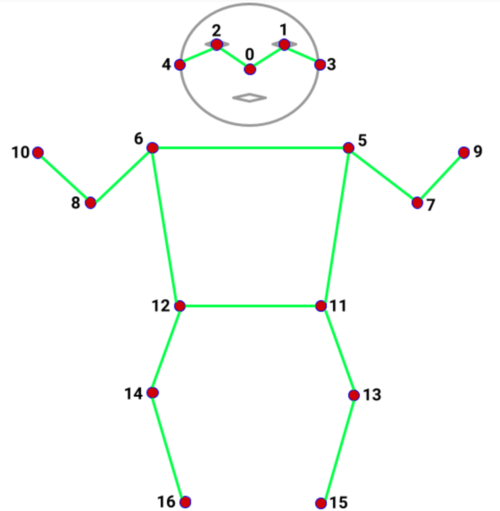

0: nose
1: left_eye
2: right_eye
3: left_ear
4: right_ear
5: left_shoulder
6: right_shoulder
7: left_elbow
8: right_elbow
9: left_wrist
10: right_wrist
11: left_hip
12: right_hip
13: left_knee
14: right_knee
15: left_ankle
16: right_ankle

Output scores for neck, shoulder, and back alignment. 0 for optimal, 1 for extremely wonky posture

In [3]:
!pip install "opencv-python-headless<4.3"

You should consider upgrading via the '/Users/jennycai/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import cv2
import numpy as np

In [5]:
# All keypoints are in (x, y, confidence score) format
KEYPOINTS=[[5.68300934e+01, 1.38610397e+02, 3.51438403e-01],
 [5.18520241e+01, 1.37883179e+02, 3.70976031e-01],
 [5.15180130e+01, 1.37135803e+02, 3.71425062e-01],
 [5.11615410e+01, 1.30476868e+02, 3.85702312e-01],
 [5.27169838e+01, 1.32083252e+02, 4.46939647e-01],
 [7.06841583e+01, 1.14333847e+02, 5.84214866e-01],
 [7.72127991e+01, 1.27044662e+02, 5.76321244e-01],
 [1.06914940e+02, 1.02550674e+02, 1.80456415e-01],
 [1.08064827e+02, 1.37802734e+02, 4.88684416e-01],
 [1.18368263e+02, 1.36768585e+02, 1.80709735e-01],
 [1.24117226e+02, 1.43527771e+02, 3.24544430e-01],
 [1.39043350e+02, 8.42426453e+01, 4.63357091e-01],
 [1.46470505e+02, 1.03517029e+02, 7.87176192e-01],
 [1.86833939e+02, 9.41186295e+01, 4.43411678e-01],
 [1.89928711e+02, 1.42338272e+02, 6.44498050e-01],
 [2.24800461e+02, 9.29078827e+01, 2.34685376e-01],
 [2.48216599e+02, 1.33284775e+02, 2.90465683e-01]]

KEYPOINTS = np.array(KEYPOINTS)[:, :2].reshape(1, 34)

## Heuristics

In [6]:
import numpy as np

def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def calculate_angle(point1, point2, point3):
    """Calculate angle between three points (in degrees).
       When considering the points, only use the (x, y) coordinates
    """
    a = np.array(point1)  # Convert point1 to a NumPy array
    b = np.array(point2)  # Convert point2 to a NumPy array
    c = np.array(point3)  # Convert point3 to a NumPy array

    # Calculate vectors from point B to point A and from point B to point C
    ba = a - b
    bc = c - b

    # Calculate the cosine of the angle between the vectors
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    
    # Ensure cosine_angle is within -1 to 1 range to avoid NaN results
    cosine_angle = np.clip(cosine_angle, -1, 1)

    # Calculate the angle in radians and then convert to degrees
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)
    return np.degrees(angle)

def normalize_score(angle, ideal_angle):
    """Normalize score between 0 and 1, where 0 is the ideal_angle."""
    deviation = abs(angle - ideal_angle)
    normalized_score = deviation / ideal_angle
    return min(normalized_score, 1)  # Ensure score does not exceed 1

In [7]:
def heuristic_posture_scores(keypoints, FRAME_HEIGHT=1080):
    """Score the postural, spinal, and shoulder alignment.
    Assuming keypoints: 0-Nose, 5-Left Shoulder, 6-Right Shoulder, 11-Left Hip, 12-Right Hip"""

    # Calculate angles
    back_angle = calculate_angle(keypoints[10:12], keypoints[22:24], keypoints[24:26])  # Shoulder to hips
    neck_head_angle = calculate_angle(keypoints[0:2], keypoints[10:12], keypoints[12:14])  # Nose to shoulders

    # Shoulder levelness: Ideal is a straight horizontal line, so difference in y-coordinates
    shoulder_levelness = abs(keypoints[10] - keypoints[11])

    # Assuming the maximum possible y-coordinate difference as the height of the frame (e.g., 1080 pixels),
    # you may adjust this based on your actual frame height
    shoulder_score = min(shoulder_levelness / FRAME_HEIGHT, 1)

    # Normalize scores (0 is best, 1 is worst)
    back_score = normalize_score(back_angle, 180)
    neck_head_score = normalize_score(neck_head_angle, 180)

    return {'back_score': back_score, 'neck_head_score': neck_head_score, 'shoulder_score': shoulder_score}
print(heuristic_posture_scores(KEYPOINTS[0]))

{'back_score': 0.514917537848034, 'neck_head_score': 0.6838958867785436, 'shoulder_score': 0.04041637842592592}


## LinReg

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

In [9]:
# Train regression model on real data points from yoga_train_data.csv

df = pd.read_csv('/Users/jennycai/Desktop/TreeHacks2024/ml/sample_data/yoga_train_data.csv') # TODO: CHANGE TO RELATIVE PATH
cols_of_interest = [
    'nose_x', 'nose_y', 'nose_score',
    'left_eye_x', 'left_eye_y', 'left_eye_score',
    'right_eye_x', 'right_eye_y', 'right_eye_score',
    'left_ear_x', 'left_ear_y', 'left_ear_score',
    'right_ear_x', 'right_ear_y', 'right_ear_score',
    'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_score',
    'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_score',
    'left_elbow_x', 'left_elbow_y', 'left_elbow_score',
    'right_elbow_x', 'right_elbow_y', 'right_elbow_score',
    'left_wrist_x', 'left_wrist_y', 'left_wrist_score',
    'right_wrist_x', 'right_wrist_y', 'right_wrist_score',
    'left_hip_x', 'left_hip_y', 'left_hip_score',
    'right_hip_x', 'right_hip_y', 'right_hip_score',
    'left_knee_x', 'left_knee_y', 'left_knee_score',
    'right_knee_x', 'right_knee_y', 'right_knee_score',
    'left_ankle_x', 'left_ankle_y', 'left_ankle_score',
    'right_ankle_x', 'right_ankle_y', 'right_ankle_score'
]
cols_of_interest = [col for col in cols_of_interest if not col.endswith('_score')]

df = df.filter(cols_of_interest)
X = df.to_numpy() # (968, 34)
num_samples = X.shape[0]

y_back, y_shoulder, y_neck_head = [], [], []
# Simulate scores for back, shoulder, and neck/head alignment (ranging from 0 to 1)
for keypoints in X:
  curr_y_back, curr_y_neck_head, curr_y_shoulder = heuristic_posture_scores(keypoints).values()
  y_back.append(curr_y_back)
  y_shoulder.append(curr_y_shoulder)
  y_neck_head.append(curr_y_neck_head)

y_back, y_shoulder, y_neck_head = np.array(y_back).reshape((num_samples, 1)), np.array(y_shoulder).reshape((num_samples, 1)), np.array(y_neck_head).reshape((num_samples, 1))

# Split data into training and testing sets
X_train, X_test, y_train_back, y_test_back = train_test_split(X, y_back, test_size=0.2, random_state=42)
_, _, y_train_shoulder, y_test_shoulder = train_test_split(X, y_shoulder, test_size=0.2, random_state=42)
_, _, y_train_neck_head, y_test_neck_head = train_test_split(X, y_neck_head, test_size=0.2, random_state=42)

In [10]:
# Train separate models for each score
model_back = LinearRegression().fit(X_train, y_train_back)
model_shoulder = LinearRegression().fit(X_train, y_train_shoulder)
model_neck_head = LinearRegression().fit(X_train, y_train_neck_head)

In [11]:
# PREDICTION. TODO: make this real-time later

score_back = model_back.predict(KEYPOINTS)
score_shoulder = model_shoulder.predict(KEYPOINTS)
score_neck_head = model_neck_head.predict(KEYPOINTS)

print(f"Predicted Back Alignment Score: {score_back[0][0]:.2f}")
print(f"Predicted Shoulder Alignment Score: {score_shoulder[0][0]:.2f}")
print(f"Predicted Neck/Head Alignment Score: {score_neck_head[0][0]:.2f}")

Predicted Back Alignment Score: 0.32
Predicted Shoulder Alignment Score: 0.05
Predicted Neck/Head Alignment Score: 0.71


## Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor

model_back = RandomForestRegressor(n_estimators=100, random_state=42)
model_back.fit(X_train, y_train_back.ravel())

model_shoulder = RandomForestRegressor(n_estimators=100, random_state=42)
model_shoulder.fit(X_train, y_train_shoulder.ravel())

model_neck_head = RandomForestRegressor(n_estimators=100, random_state=42)
model_neck_head.fit(X_train, y_train_neck_head.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [13]:
score_back = model_back.predict(KEYPOINTS)
score_shoulder = model_shoulder.predict(KEYPOINTS)
score_neck_head = model_neck_head.predict(KEYPOINTS)

print(f"Predicted Back Alignment Score: {score_back[0]:2f}")
print(f"Predicted Shoulder Alignment Score: {score_shoulder[0]:.2f}")
print(f"Predicted Neck/Head Alignment Score: {score_neck_head[0]:.2f}")

Predicted Back Alignment Score: 0.447258
Predicted Shoulder Alignment Score: 0.04
Predicted Neck/Head Alignment Score: 0.73


# Boosting Regressor

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

model_back = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_back.fit(X_train, y_train_back.ravel())

model_shoulder = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_shoulder.fit(X_train, y_train_shoulder.ravel())

model_neck_head = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_neck_head.fit(X_train, y_train_neck_head.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
score_back = model_back.predict(KEYPOINTS)
score_shoulder = model_shoulder.predict(KEYPOINTS)
score_neck_head = model_neck_head.predict(KEYPOINTS)

print(f"Predicted Back Alignment Score: {score_back[0]:2f}")
print(f"Predicted Shoulder Alignment Score: {score_shoulder[0]:.2f}")
print(f"Predicted Neck/Head Alignment Score: {score_neck_head[0]:.2f}")

Predicted Back Alignment Score: 0.432314
Predicted Shoulder Alignment Score: 0.02
Predicted Neck/Head Alignment Score: 0.76
